공부를 하기 싫어서 주식 차트를 보다가 문득 `주식은 결국 쌀 때 사고, 비쌀 때 팔면 되는거지. 그럼 간단하게 오르면 팔고 내리면 사면 되는거아닐까?`라는 잡스러운 생각을 해버렸고 한번 실제로 되나 체크해보기 위해 다음과 같은 코드를 싸질러봤다.

In [1]:
pip install finance-datareader

Note: you may need to restart the kernel to use updated packages.


In [10]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# AAPL이 거래되기 시작한 날부터 현재까지 전체 데이터
df = fdr.DataReader('AAPL') # 역시 시총 1위 기업 애아뽀으
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099584,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094388,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087461,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089625,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092224,73449600
...,...,...,...,...,...,...
2023-08-03,191.570007,192.369995,190.690002,191.169998,191.169998,61235200
2023-08-04,185.520004,187.380005,181.919998,181.990005,181.990005,115799700
2023-08-07,182.130005,183.130005,177.350006,178.850006,178.850006,97576100


<AxesSubplot: xlabel='Date'>

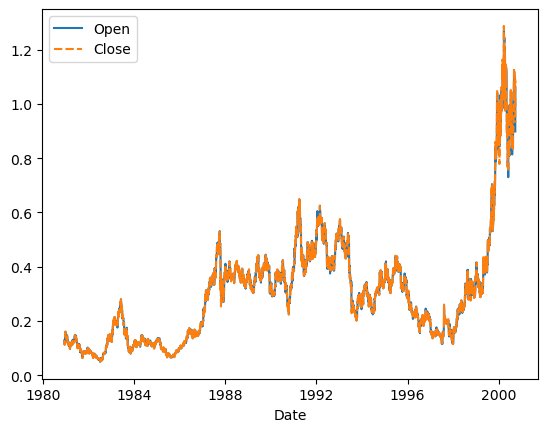

In [17]:
sns.lineplot(df[['Open','Close']][:5000]) # 뭐 대충 절반의 흐름이 이렇다. open하고 close의 차이는 엄청 극적이진 않다.

내가 지금 만들려는 모델은 간단하다. 전날 하락했으면 전체에서 100등분한 것중에 한개를 시가로 주고 산다.(open > close) 그리고 전날 상승했으면 가지고 있는 것중에 한개를 시가로 판다.(open < close)

In [38]:
# 시작은 1000달러
start = 1000

# 금액이 아닌 전체 돈의 단위로 계산을 할 것이다.
tot = 200 #내가 나눌 단위
split = 200 # 현재 가지고 있는 돈에서 살 수 있는 단위
apple = 0 # 내가 현재 가지고 있는 애플의 주식 수

ctr_list = []
apl_list = []

# 주식 시장에 존재했던 일수
for buy in range(len(df)-1):
    if split == 200:
        if df['Open'][buy] - df['Close'][buy] > 0: # 주가가 하락했으면
            apple += start/split/df['Open'][buy+1] # 구매하는 애플 주식의 수
            start -= start/split # 현재 자금 -
            split -= 1
    elif 200 > split and split > 0: # 내가 현재 주식을 살 돈이 존재할 때
        if df['Open'][buy] - df['Close'][buy] > 0: # 주가가 하락했으면
            apple += start/split/df['Open'][buy+1] # 구매하는 애플 주식의 수
            start -= start/split # 현재 자금 -
            split -= 1
        elif df['Open'][buy] - df['Close'][buy] < 0: # 주가가 상승했으면
            apple -= apple/(tot-split) # 판매하는 주식 수
            start += apple/(tot-split)*df['Open'][buy+1] # 늘어나는 자본금
            split += 1   
    elif split == 0:
        if df['Open'][buy] - df['Close'][buy] < 0: # 주가가 상승했으면
            apple -= apple/(tot-split) # 판매하는 주식 수
            start += apple/(tot-split)*df['Open'][buy+1] # 늘어나는 자본금
            split += 1 
    ctr_list.append(start)
    apl_list.append(apple)

In [39]:
df['Open'][0]

0.128348

<AxesSubplot: >

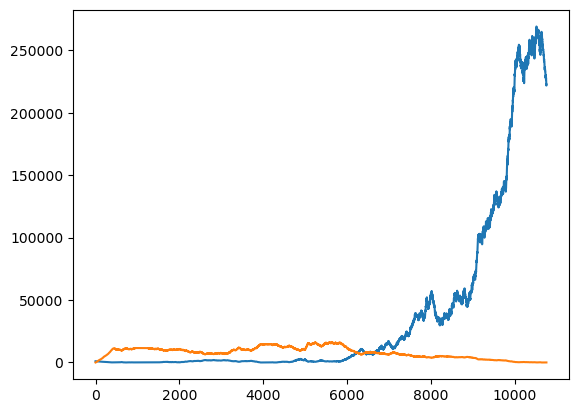

In [40]:
sns.lineplot(ctr_list)
sns.lineplot(apl_list)

<AxesSubplot: xlabel='Date', ylabel='Open'>

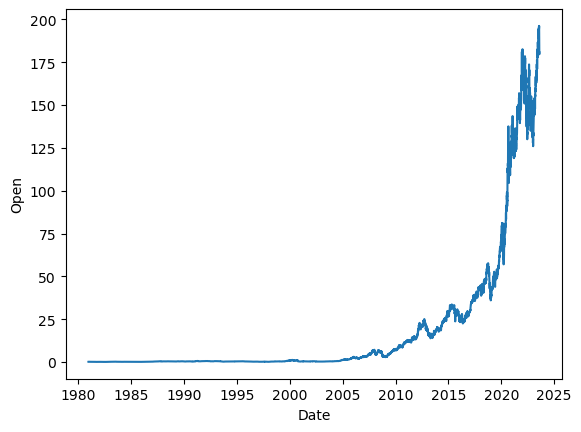

In [27]:
sns.lineplot(df['Open'])

그럼 전체돈을 몇개로 쪼갤 때가 가장 좋은 결과를 보일까?\
100, 200개 두들겨봤는데 100<<200이어서 한번 해봄. 마지막을 기준으로 가장 높은 값을 찾아보고자 한다.

In [51]:
# 시작은 1000달러
start = 1000

# 금액이 아닌 전체 돈의 단위로 계산을 할 것이다.
tot = range(1,1001) #내가 나눌 단위(총 1000개까지)

apple = 0 # 내가 현재 가지고 있는 애플의 주식 수

end_money = []

# 주식 시장에 존재했던 일수
for x in range(1,1001):
    split = x
    end = x
    start = 1000
    for buy in range(len(df)-1):
        if split == end:
            if df['Open'][buy] - df['Close'][buy] > 0: # 주가가 하락했으면
                apple += start/split/df['Open'][buy+1] # 구매하는 애플 주식의 수
                start -= start/split # 현재 자금 -
                split -= 1
        elif end > split and split > 0: # 내가 현재 주식을 살 돈이 존재할 때
            if df['Open'][buy] - df['Close'][buy] > 0: # 주가가 하락했으면
                apple += start/split/df['Open'][buy+1] # 구매하는 애플 주식의 수
                start -= start/split # 현재 자금 -
                split -= 1
            elif df['Open'][buy] - df['Close'][buy] < 0: # 주가가 상승했으면
                apple -= apple/(end-split) # 판매하는 주식 수
                start += apple/(end-split)*df['Open'][buy+1] # 늘어나는 자본금
                split += 1   
        elif split == 0:
            if df['Open'][buy] - df['Close'][buy] < 0: # 주가가 상승했으면
                apple -= apple/(end-split) # 판매하는 주식 수
                start += apple/(end-split)*df['Open'][buy+1] # 늘어나는 자본금
                split += 1 
    end_money.append(start)

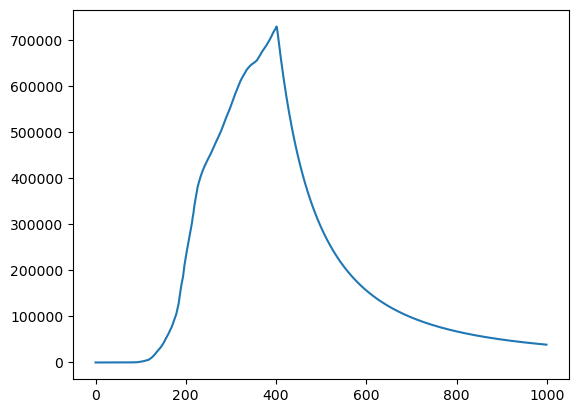

In [52]:
plt.plot(end_money)

In [53]:
max(end_money)

728696.9126243156

In [54]:
end_money.index(max(end_money))

401

현재 애플같은 경우에는 401개로 돈을 쪼갰을 때 가장 좋은 결과를 보았다. 이게 다른 주식에도, 전체 지수에서도 적용되나 한번쯤 해봐야지
하지만 주인장이 게을러서 언제 할지는 모름 ㅋ